## Imports

In [1]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from numpy import linalg as LA

## Constants

In [2]:
L = 1.0                            # length of the rod (m)
A = 0.0001                         # cross-sectional area of the rod (m^2)
rho = 1600                         # density of the rod (kg/m^3)
E = 2e7                            # Young's modulus of the rod (Pa)
c = np.sqrt((E*1e-6) / (rho*1e-3)) # wave speed (m/s)

## Functions

In [3]:
def get_displacement(L, dx, scale_param):
    """ 
    Returns the displacement and initial u matrix
    """
    x = np.arange(0, scale_param*L + dx, dx)
    u = np.zeros_like(x)
    u[1:-1] = np.sin(np.pi * x[1:-1] / L) * 0.1  # reduce the amplitude of the initial displacement
    return u, x

def d2udx2(u, t, dx):
    """ 
    Returns the 2nd derivative w.r.t. x using the central difference method
    """
    d2u_dx2 = np.zeros_like(u)
    for i in range(1, len(d2u_dx2) - 1):
        d2u_dx2[i] = (u[i+1] - 2*u[i] + u[i-1]) / dx**2
    return c**2 * d2u_dx2 - E*A/rho * u

def RK4(u, t, dx, dt):
    """ 
    Returns the u matrix at the next time step via the RK4 method
    """
    k1 = dt * d2udx2(u, t, dx)
    k2 = dt * d2udx2(u + k1/2, t + dt/2, dx)
    k3 = dt * d2udx2(u + k2/2, t + dt/2, dx)
    k4 = dt * d2udx2(u + k3, t + dt, dx)
    return u + 1/6 * (k1 + 2*k2 + 2*k3 + k4)

def u_e(x, t):
    """
    Returns the exact solution for the displacement of the rod
    """
    return np.sin(np.pi * x / L) * 0.1 * np.cos(c * t)
    

def forward_euler(u, t, dx, dt):
    """
    Returns the u matrix at the next time step via the Forward Euler method
    """
    return u + dt * u_e(dx, t)


def get_final_u(u_init, dx, dt, t, method):
    """ 
    Returns the final u matrix after the final time step in the simulation using the specified method
    """
    if method == 'RK4':
        update_fn = RK4
        for i in range(int(t / dt)):
            u = RK4(u_init, i * dt, dx, dt)
    elif method == 'Forward Euler':
        update_fn = forward_euler
        for i in range(int(t / dt)):
            u = forward_euler(u_init, i * dt, dx, dt)
    else:
        raise ValueError("Invalid method selected. Choose either 'RK4' or 'Forward Euler'")
    
    return u


dx = 0.01
dt = 0.00025
sim_T = 0.01
scale_param = 10
x = np.linspace(0, scale_param*L, int(4*sim_T / dt))
t = np.arange(0, sim_T, dt/4)

u_initial, x_final = get_displacement(L, dx, scale_param)
u_final_RK4 = get_final_u(u_initial, dx, dt, sim_T, method='RK4')
u_final_FE = get_final_u(u_initial, dx, dt, sim_T, method='Forward Euler')
u_exact = u_e(x, t)

## Solution Plots

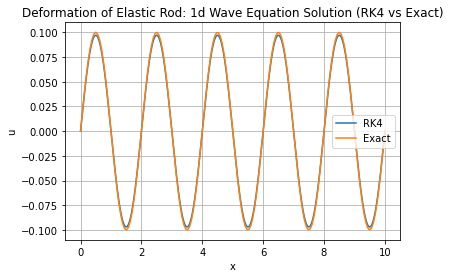

In [4]:
plt.plot(x_final, u_final_RK4, label='RK4')
plt.plot(x, u_exact, label='Exact')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Deformation of Elastic Rod: 1d Wave Equation Solution (RK4 vs Exact)')
plt.legend()
plt.grid()
plt.show()

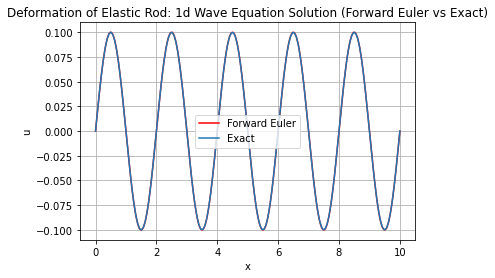

In [5]:
plt.plot(x_final, u_final_FE, label='Forward Euler', color = 'r')
plt.plot(x, u_exact, label='Exact')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Deformation of Elastic Rod: 1d Wave Equation Solution (Forward Euler vs Exact)')
plt.legend()
plt.grid()
plt.show()

## Error

In [6]:
def RK4_error(u, u_true):
    """
    Returns error between RK4 solution and exact solution
    """
    err = np.linalg.norm(u - u_true) / np.linalg.norm(u_true)
    return err

def forward_euler_error(u, u_true):
    """
    Returns error between Forward Euler solution and exact solution
    """
    err = np.linalg.norm(u - u_true) / np.linalg.norm(u_true)
    return err

## Error Plots

<Figure size 800x600 with 0 Axes>

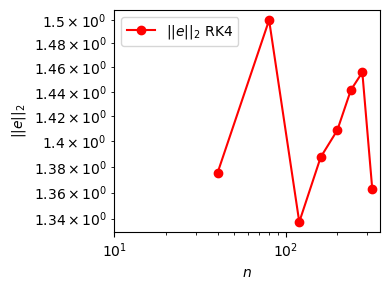

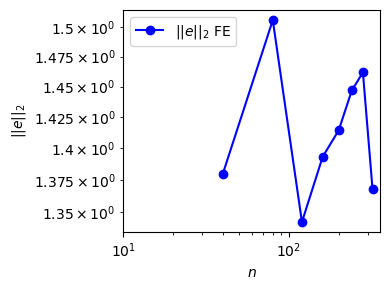

In [7]:
plt.style.use('default')

n_list = [40, 80, 120, 160, 200, 240, 280, 320]
err_list_RK4 = []
err_list_FE = []
for n in n_list:
    x_plot = np.linspace(0, scale_param*L, n+1)
    t_plot = np.linspace(0, sim_T, n+1)
    dt_plot = t[1] - t[0]
    
    u_RK4 = get_final_u(u_initial, dx, dt_plot, sim_T, 'RK4')[0:n+1]
    u_FE = get_final_u(u_initial, dx, dt_plot, sim_T, 'Forward Euler')[0:n+1]
    u_true = u_e(x_plot, t_plot)
    err_list_RK4.append(RK4_error(u_RK4, u_true))
    err_list_FE.append(forward_euler_error(u_FE, u_true))

fig = plt.figure(figsize=(8, 6), tight_layout=True)

# plot error vs. n
fig = plt.figure(figsize=(4, 3), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(n_list, err_list_RK4, 'ro-', label='$||e||_2$ RK4')
ax.set_xlabel('$n$')
ax.set_ylabel('$||e||_2$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([10, 100])
ax.legend()

fig = plt.figure(figsize=(4, 3), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(n_list, err_list_FE, 'bo-', label='$||e||_2$ FE')
ax.set_xlabel('$n$')
ax.set_ylabel('$||e||_2$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([10, 100])
ax.legend()